Get the data

In [23]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
driver = 'mysql+pymysql:'
user = 'root'
password = '17028854'
ip = '35.195.111.11'
database = 'Avocalypse'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [4]:
gtrend = pd.read_sql('gtrend',con=engine)

In [5]:
gtrend['year'] = gtrend['year'].astype('int64')
gtrend['month'] = gtrend['month'].astype('int64')
gtrend['popularity'] = gtrend['popularity'].astype('int64')

In [6]:
gtrend_2006_2016 = gtrend[gtrend['year']>2005]
gtrend_2006_2016 = gtrend_2006_2016[gtrend_2006_2016['year']<2017]

We will plot a linear model and check the fit

In [27]:
graph_df = gtrend_2006_2016

In [31]:
graph_df.head(2)

,time,time,year,month,popularity
0,0,0,2006,1,18
1,1,1,2006,2,17


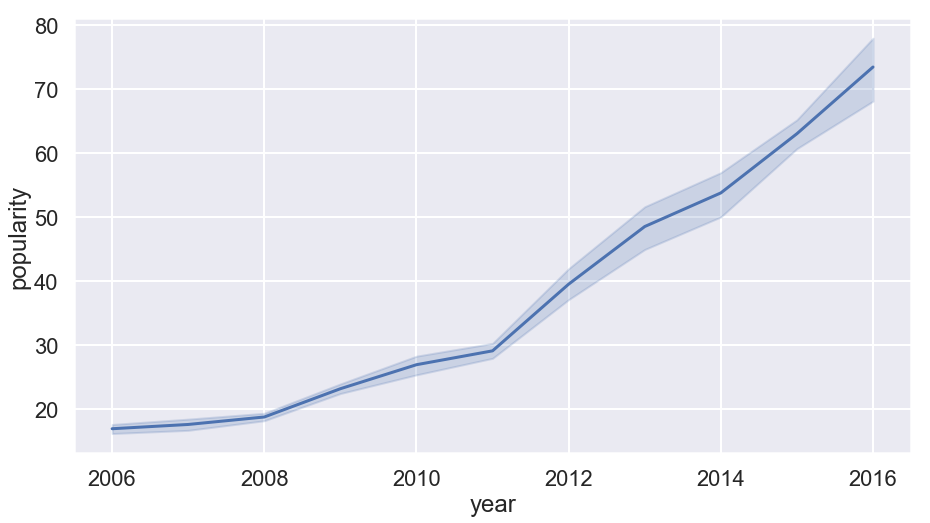

In [71]:
sns.lineplot(x="year", y="popularity", data=gtrend_2006_2016)

In [72]:
gtrend_2006_2016 = gtrend_2006_2016.reset_index(drop=True).reset_index().rename(columns={'index':'time'})


In [73]:
gtrend_2006_2016_yearly = gtrend_2006_2016.groupby('year').mean().reset_index()

In [78]:
gtrend_2006_2016_yearly.head(2)

,year,time,time,time,time,month,popularity,regression
0,2006,5.5,5.5,5.5,5.5,6.5,16.916667,16.233529
1,2007,17.5,17.5,17.5,17.5,6.5,17.583333,17.289370


I include here the regression found in "mycurvefit.com"

In [76]:
gtrend_2006_2016_yearly['regression']=2097337-2091.582*gtrend_2006_2016_yearly['year']+0.5214647*gtrend_2006_2016_yearly['year']**2
graph_df = gtrend_2006_2016_yearly 

In [79]:
graph_df.head(2)

,year,time,time,time,time,month,popularity,regression
0,2006,5.5,5.5,5.5,5.5,6.5,16.916667,16.233529
1,2007,17.5,17.5,17.5,17.5,6.5,17.583333,17.289370


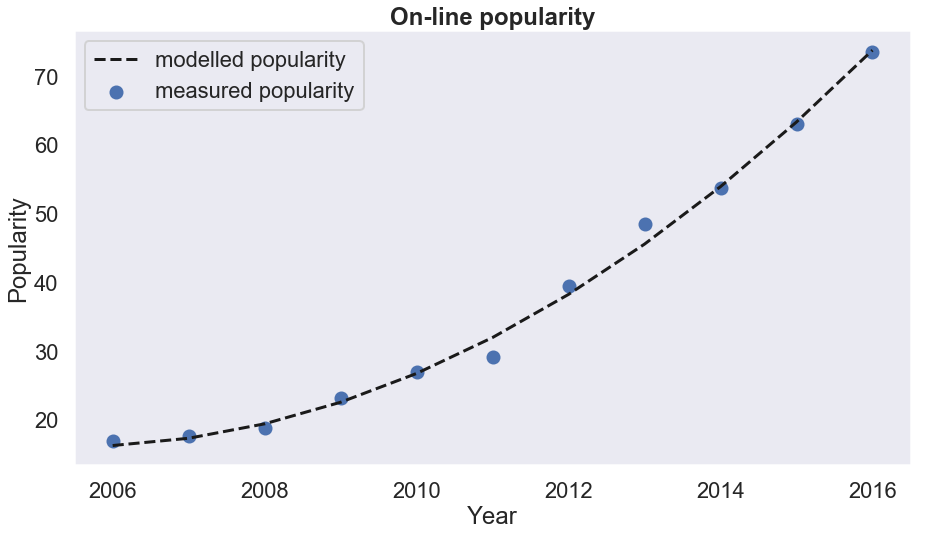

In [109]:
plt.scatter(graph_df.year, graph_df.popularity, label='measured popularity')
plt.plot(graph_df.year, graph_df.regression, 'k--', label='modelled popularity')
plt.title('On-line popularity', fontweight = 600)
plt.ylabel('Popularity')
plt.xlabel('Year')
plt.grid(b=None)
plt.legend()
plt.savefig('popularity.png',transparent=True)
plt.show()

Get data for pricing

In [83]:
prices = pd.read_sql('prices',con=engine)
countries = pd.read_sql('countries',con=engine)

In [84]:
countries = countries.drop(columns='index')
prices = prices.drop(columns='index')
prices_country = prices.merge(countries, how='left', on='Area Code')

We use the top10 producing countries so we'll use the prices only for the top10 prod countries

In [90]:
top10_2016 = ['Mexico', 'Dominican Republic', 'Peru', 'Indonesia', 'Colombia', 'Brazil', 'Kenya', 'Chile', 'Venezuela (Bolivarian Republic of)', 'United States of America', 'China']

In [91]:
prices_country.head(2)

,Area Code,Year Code,Value,Area
0,9,2007,123.086061,Argentina
1,9,2008,155.952012,Argentina


In [92]:
top10_prices = prices_country[prices_country['Area'].isin(top10_2016)]

In [93]:
inflation = pd.read_sql('inflation',con=engine)

In [94]:
inflation = inflation.rename(columns={'Value':'inflation'}).drop(columns='index')

In [95]:
top10_prices = top10_prices.merge(inflation,how='left',left_on=['Year Code','Area'],right_on=['Year','country'])

We drop Venezuela due to missing data on inflation

In [96]:
top10_prices = top10_prices[:104]

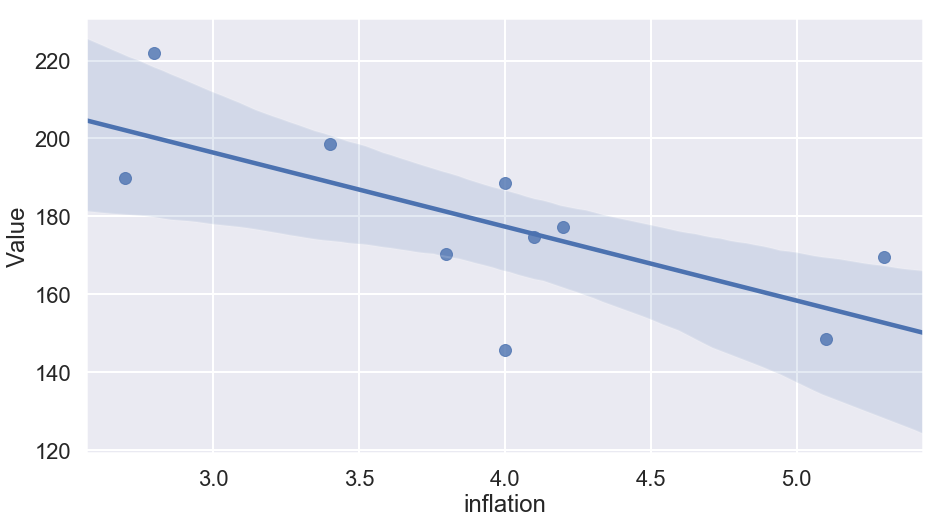

In [58]:
sns.regplot(data=top10_prices[top10_prices['country']=='Mexico'],x='inflation',y='Value')

There is no relation between inflation and the price of avocado. Mexico is shown as an example only

In [59]:
top10_prices_yearly = top10_prices.groupby('Year Code').mean().reset_index()[['Year Code','Value','inflation']]

In [60]:
top10_prices_yearly.head()

,Year Code,Value,inflation
0,2007,122.928843,4.800000
1,2008,149.552836,8.711111
2,2009,155.572161,3.355556
3,2010,171.981252,3.144444
4,2011,191.596539,5.366667


In [61]:
summary_data = top10_prices_yearly.merge(gtrend_2006_2016_yearly,how='inner',left_on='Year Code',right_on = 'year')

In [97]:
#Regression found, with R**2 = 0.8918, aR**2=0.8455, P=0.0009273, F=19.24
Y0=-265.8751
V0=-50.14305
k=0.1074086

In [63]:
summary_data['regression_value']=Y0-(V0/k)*(1-np.exp(-k*summary_data['popularity']))

In [64]:
summary_data.to_csv('correlation_model.csv')
summary_data.to_excel('correlation_model.xls')

In [127]:
summary_data = summary_data.drop(columns='time')
summary_data = summary_data.drop(columns='month')

In [123]:
reg_x = np.linspace(15,100,300)
reg_y = Y0-(V0/k)*(1-np.exp(-k*reg_x))
print(reg_x.shape, reg_y.shape)

(300,) (300,)


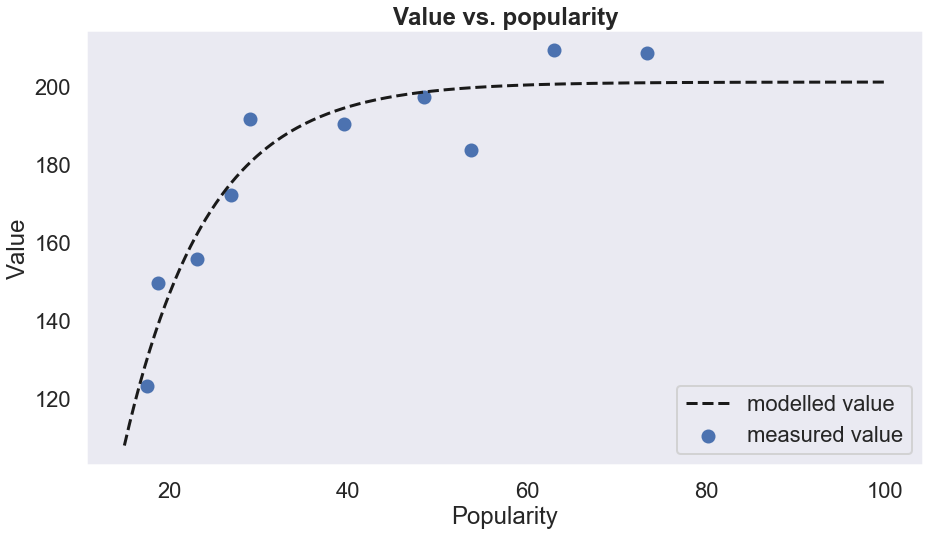

In [125]:
plt.scatter(summary_data.popularity, summary_data.Value, label='measured value')
plt.plot(reg_x, reg_y, 'k--', label='modelled value')
plt.title('Value vs. popularity', fontweight=600)
plt.ylabel('Value')
plt.xlabel('Popularity')
plt.grid(b=None)
plt.legend(loc=4)
plt.savefig('value_popularity.png',transparent=True)
plt.show()